In [1]:
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
import os
from dotenv import load_dotenv
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle as pkl
import json

In [2]:
RANDOM_STATE = 42

# Read Data

In [3]:
# Curry function to initialize postgres engine and return read_query function

def make_read_query(protocol=None, user=None, password=None, host=None, port=None, db=None):
    load_dotenv()
    
    protocol = protocol if protocol else 'postgresql+psycopg2'
    user = user if user else os.environ.get('POSTGRES_USER')
    password = password if password else os.environ.get('POSTGRES_PASSWORD')
    host = host if host else 'localhost'
    port = port if port else 5432
    db = db if db else os.environ.get('POSTGRES_DB')
    
    db_url = f'{protocol}://{user}:{password}@{host}:{port}/{db}'
    engine = create_engine(db_url)

    def read_query(query, verbose=True):
        if verbose:
            print(query, '\n')
            
        with engine.connect() as conn:
            df = sqlio.read_sql_query(query, conn)

        return df

    return read_query

In [4]:
read_query = make_read_query()

In [5]:
users_enriched = read_query("SELECT * FROM users_enriched")
users_enriched.head()

SELECT * FROM users_enriched 



,id,age,gender,country,city,traffic_source,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,...,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value,first_order_value,first_order_categories,first_order_brands,lifetime_status,segment
0,56219,60,F,United States,Philadelphia,Facebook,2019-01-02 00:06:00,2021-05-27 23:07:12,2021-05-27 23:07:12,876.0,...,0.0,1,1.0,74.990,74.990,74.99,{Jeans},{Wrangler},One-Off Purchaser,One-Off Customers
1,72034,70,F,South Korea,Seoul,Organic,2019-01-02 00:36:00,2021-07-30 12:35:12,2023-04-21 14:50:59,940.0,...,0.0,2,1.0,221.500,221.500,44.00,{Intimates},"{""Yummie Tummie""}",Churn Likely,High Value Item Purchaser
2,21731,65,F,China,Harbin,Email,2019-01-02 01:47:00,2023-09-17 22:23:37,2023-09-17 22:23:37,1719.0,...,0.0,1,4.0,60.985,243.940,243.94,"{""Tops & Tees"",Accessories,Maternity,""Blazers ...","{Patty,Modadorn,""Bella Materna"",FactoryExtreme}",One-Off Purchaser,One-Off Customers
3,39594,17,M,China,Shenzhen,Search,2019-01-02 03:00:00,2019-02-11 03:06:43,2019-10-25 02:29:03,40.0,...,0.0,2,1.0,35.975,35.975,51.96,"{""Fashion Hoodies & Sweatshirts""}",{Billabong},Churn Likely,Single-Item Purchaser
4,2000,30,F,China,Hefei,Search,2019-01-02 03:19:00,NaT,NaT,NaN,...,NaN,0,NaN,NaN,NaN,NaN,None,None,Inactive,Never Ordered


In [6]:
users_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84011 entries, 0 to 84010
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      84011 non-null  int64         
 1   age                     84011 non-null  int64         
 2   gender                  84011 non-null  object        
 3   country                 84011 non-null  object        
 4   city                    84011 non-null  object        
 5   traffic_source          84011 non-null  object        
 6   created_at              84011 non-null  datetime64[ns]
 7   first_order_timestamp   69073 non-null  datetime64[ns]
 8   last_order_timestamp    69073 non-null  datetime64[ns]
 9   days_to_activation      69073 non-null  float64       
 10  active_days             69073 non-null  float64       
 11  inactive_days           69073 non-null  float64       
 12  avg_days_to_order       30731 non-null  float6

In [7]:
users_enriched.describe()

,id,age,created_at,first_order_timestamp,last_order_timestamp,days_to_activation,active_days,inactive_days,avg_days_to_order,std_days_to_order,n_orders,avg_order_items,avg_item_value,avg_order_value,first_order_value
count,84011.000000,84011.000000,84011,69073,69073,69073.000000,69073.000000,69073.000000,30731.000000,69073.000000,84011.000000,69073.000000,69073.000000,69073.000000,69073.000000
mean,50046.114747,41.056743,2021-06-14 10:42:19.902130176,2022-07-16 08:15:15.045710592,2023-01-26 08:13:51.547237632,404.987101,193.778872,740.973767,275.818590,32.529947,1.490591,1.450729,59.255161,86.006317,85.800945
min,1.000000,12.000000,2019-01-02 00:06:00,2019-01-06 02:25:41,2019-01-06 02:25:41,0.000000,0.000000,381.000000,0.000000,0.000000,0.000000,1.000000,0.490000,0.490000,0.490000
25%,25058.500000,26.000000,2020-02-20 04:11:00,2021-09-13 00:20:14,2022-08-05 07:17:34,93.000000,0.000000,455.000000,82.500000,0.000000,1.000000,1.000000,30.245000,36.083333,29.500000
50%,50075.000000,41.000000,2021-05-23 03:56:00,2022-10-20 18:26:08,2023-06-03 08:41:08,284.000000,0.000000,613.000000,197.000000,0.000000,1.000000,1.000000,47.432500,64.240000,55.000000
75%,75034.500000,56.000000,2022-09-24 04:51:30,2023-07-30 10:50:57,2023-11-08 10:31:21,617.000000,269.000000,915.000000,379.000000,0.000000,2.000000,2.000000,70.982500,109.231429,109.500000
max,100000.000000,70.000000,2024-01-16 19:46:14.316147,2024-01-21 10:09:51.990337,2024-01-21 12:55:19.720387,1828.000000,1784.000000,2222.000000,1744.000000,1100.965258,40.000000,4.000000,999.000000,1341.490000,1341.490000
std,28875.397764,17.035458,NaN,NaN,NaN,386.041580,334.320750,366.613107,268.153338,97.139166,1.363647,0.691586,50.940926,79.785017,93.215557


# EDA

In [8]:
inactive_users = users_enriched.loc[users_enriched.n_orders==0].copy()
one_off_customers = users_enriched.loc[users_enriched.n_orders==1].copy()
repeat_purchasers = users_enriched.loc[users_enriched.n_orders>1].copy()

print('Repeat Purchasers:', repeat_purchasers.shape[0], 
      'One-Off Customers', one_off_customers.shape[0], 
      'Inactive Users', inactive_users.shape[0])

Repeat Purchasers: 30731 One-Off Customers 38342 Inactive Users 14938


In [9]:
one_off_customers['segment'] = 'One-Off Customers'
inactive_users['segment'] = 'Never Ordered'

In [10]:
CLUSTERING_FEATURES = ['n_orders', 'avg_days_to_order', 'avg_order_items', 'avg_item_value']
X = repeat_purchasers[CLUSTERING_FEATURES]

In [11]:
X.describe()

,n_orders,avg_days_to_order,avg_order_items,avg_item_value
count,30731.000000,30731.000000,30731.000000,30731.000000
mean,2.827243,275.818590,1.452578,59.684197
std,1.384398,268.153338,0.512634,37.150316
min,2.000000,0.000000,1.000000,4.470000
25%,2.000000,82.500000,1.000000,36.790000
50%,2.000000,197.000000,1.333333,51.460000
75%,3.000000,379.000000,1.666667,71.968750
max,40.000000,1744.000000,4.000000,745.000000


In [12]:
def plot_histograms(df, columns=None, width=14, height=7, bins=20):
    columns = df.columns if columns is None else columns
    n_subplots = len(columns)
    n_subplot_rows = round(np.sqrt(n_subplots))
    n_subplot_cols = n_subplots / n_subplot_rows

    n_subplot_cols = int(n_subplot_cols) + 1 if n_subplot_cols % 1 > 0 else int(n_subplot_cols)
    
    fig, axs = plt.subplots(n_subplot_rows, n_subplot_cols)
    fig.set_figwidth(14)
    fig.set_figheight(7)

    for i, col in enumerate(columns):
        ax_row = i // n_subplot_cols
        ax_col = i % n_subplot_cols
        ax = axs[ax_row,ax_col]
        ax.set_title(col)
        df[col].hist(bins=bins, ax=ax)

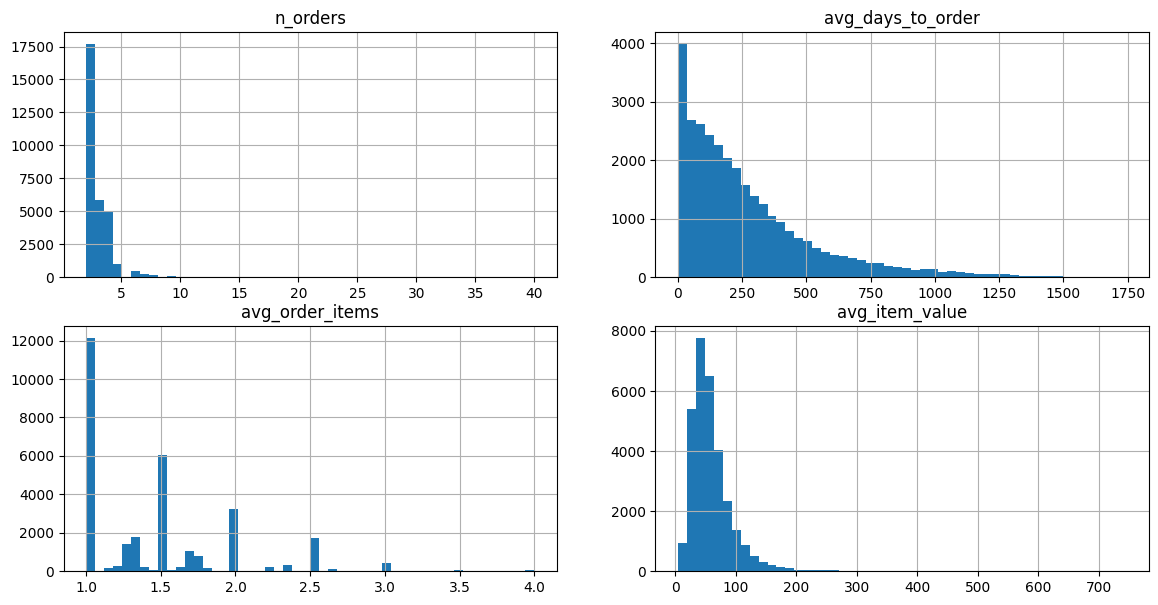

In [13]:
plot_histograms(X, bins=50)

<Axes: xlabel='n_orders', ylabel='avg_days_to_order'>

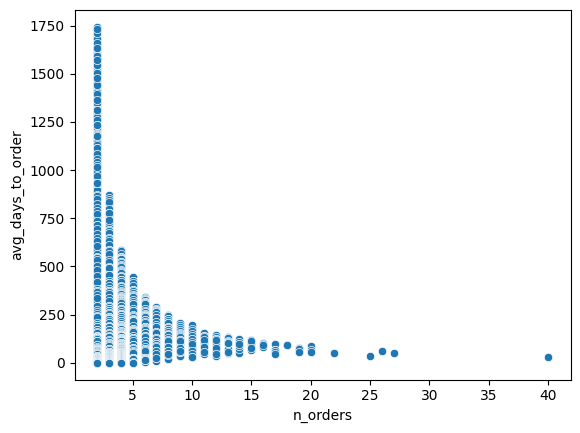

In [14]:
sns.scatterplot(X, x='n_orders', y='avg_days_to_order')

<Axes: xlabel='avg_order_items', ylabel='avg_item_value'>

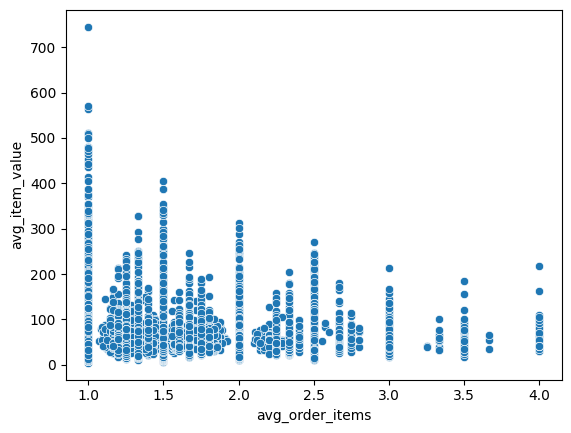

In [15]:
sns.scatterplot(X, x='avg_order_items', y='avg_item_value')

<Axes: xlabel='avg_days_to_order', ylabel='avg_item_value'>

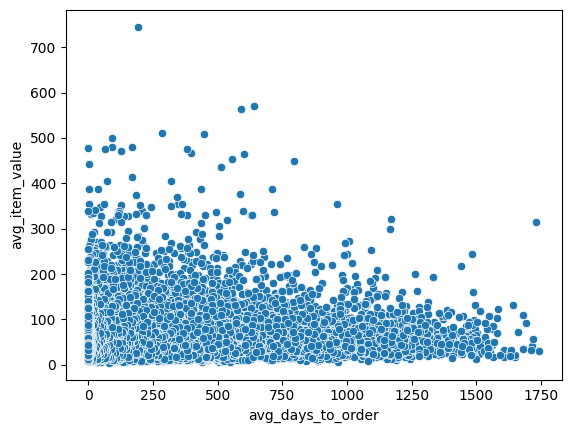

In [16]:
sns.scatterplot(X, x='avg_days_to_order', y='avg_item_value')

<Axes: >

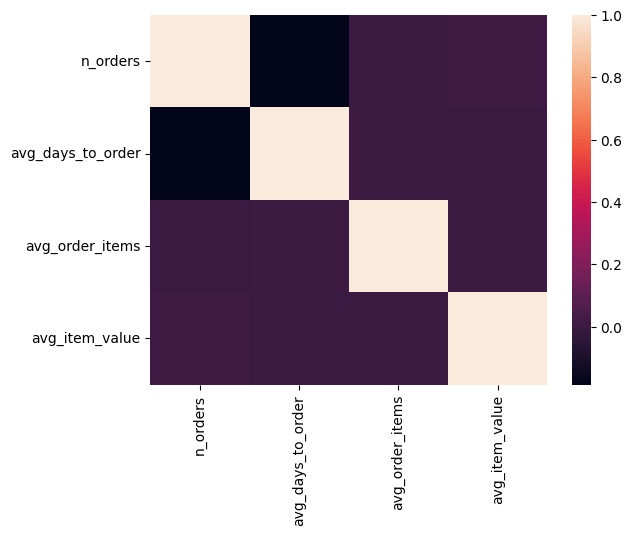

In [17]:
sns.heatmap(X.corr())

# Clustering Repeat Purchasers

In [18]:
def model_results_to_df(results, explode_hyperparams=True):
    df = pd.DataFrame(results)
    if explode_hyperparams:
        df_hyperparams = pd.DataFrame(df['hyperparams'].tolist())
        df = pd.concat([df, df_hyperparams], axis=1)\
                .drop(columns='hyperparams')
    return df

def search_clustering_hyperparams(model_type, hyperparams, X, random_state=None, verbose=True, explode_hyperparams=True):
    results = []
    for hyperparams_iter in hyperparams:
        if random_state:
            hyperparams_iter['random_state'] = random_state
            
        model = model_type(**hyperparams_iter)
        y = model.fit_predict(X)

        silhouette = silhouette_score(X, y)
        inertia = model.inertia_ if model_type == KMeans else None
        results_dict = { 
            'hyperparams': hyperparams_iter, 
            'model': model, 
            'silhouette_score': silhouette,
            'inertia': inertia
        }
        results.append(results_dict)

        if verbose:
            print(hyperparams_iter, f'Silhouette Score: {silhouette}', f'Inertia: {inertia}', sep=' | ')

    df_results = model_results_to_df(results, explode_hyperparams=True)
    
    return df_results

In [19]:
def plot_clusters(X, y, figwidth=15, figheight=10, bins=20):
    X = pd.DataFrame(X) if type(X) != pd.DataFrame else X
    labels = np.unique(y)

    fig, axs = plt.subplots(len(labels), len(X.columns))
    fig.set_figwidth(figwidth)
    fig.set_figheight(figheight)
    fig.suptitle('Cluster Feature Histograms')
    fig.subplots_adjust(wspace=0.3, hspace=0.3)

    col_mins = {}
    col_maxs = {}
    col_means = {}
    for col in X.columns:
        col_mins[col] = X[col].min()
        col_maxs[col] = X[col].max()
        col_means[col] = X[col].mean()

    for i, label in enumerate(labels):
        X_cluster = X.loc[y==label]
        for j, col in enumerate(X.columns):        
            ax = axs[i,j]
            ax.set_xlim(col_mins[col], col_maxs[col])
            if j == 0:
                ax.set_ylabel(label)
            if i == len(labels) - 1:
                ax.set_xlabel(col)
            
            X_cluster[col].hist(ax=ax, bins=bins)
            cluster_col_mean = X_cluster[col].mean()
            ymax = pd.cut(X_cluster[col], bins).value_counts().max()
            ax.vlines(cluster_col_mean, ymin=0, ymax=ymax, color='tab:orange', label='Cluster Mean')
            ax.vlines(col_means[col], ymin=0, ymax=ymax, color='tab:red', label='Sample Mean')

    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

In [28]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.        ,  1.46037099, -0.5       ,  4.83359983],
       [ 0.        ,  0.19561551, -0.5       , -0.44018051],
       [ 4.        ,  0.18684654,  0.25      ,  0.21240727],
       ...,
       [ 0.        , -0.66441821,  0.25      ,  1.5976501 ],
       [ 0.        , -0.66441821, -0.5       ,  0.88391429],
       [ 0.        , -0.66441821,  1.        ,  1.00664464]],
      shape=(30731, 4))

In [29]:
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-0.96780254,  4.61526107,  1.00938335],
       [-0.80739071, -0.6557315 , -0.25675318],
       [ 3.1242781 , -0.0783135 ,  0.55451673],
       ...,
       [-0.60246008,  1.37946608, -1.06638138],
       [-0.61375577,  0.66941348, -1.0924494 ],
       [-0.61363207,  0.78500208, -1.04702979]], shape=(30731, 3))

In [31]:
hyperparams = [{'n_clusters': i} for i in range(2, 11)]
results = search_clustering_hyperparams(KMeans, hyperparams, X_pca, random_state=RANDOM_STATE)

{'n_clusters': 2, 'random_state': 42} | Silhouette Score: 0.2903828969803482 | Inertia: 99164.0601720937
{'n_clusters': 3, 'random_state': 42} | Silhouette Score: 0.3611318096270829 | Inertia: 67821.97515849877
{'n_clusters': 4, 'random_state': 42} | Silhouette Score: 0.3875285135907855 | Inertia: 51968.73140351336
{'n_clusters': 5, 'random_state': 42} | Silhouette Score: 0.4007377456379348 | Inertia: 39629.350069987995
{'n_clusters': 6, 'random_state': 42} | Silhouette Score: 0.3778872597692919 | Inertia: 33850.88533094499
{'n_clusters': 7, 'random_state': 42} | Silhouette Score: 0.34404996254999437 | Inertia: 30921.519660176848
{'n_clusters': 8, 'random_state': 42} | Silhouette Score: 0.3490863843902256 | Inertia: 27227.864633699188
{'n_clusters': 9, 'random_state': 42} | Silhouette Score: 0.3512694579166342 | Inertia: 25114.655113834706
{'n_clusters': 10, 'random_state': 42} | Silhouette Score: 0.33531767509348315 | Inertia: 22662.207494931976


<Axes: title={'center': 'Silhouette Score'}, xlabel='n_clusters'>

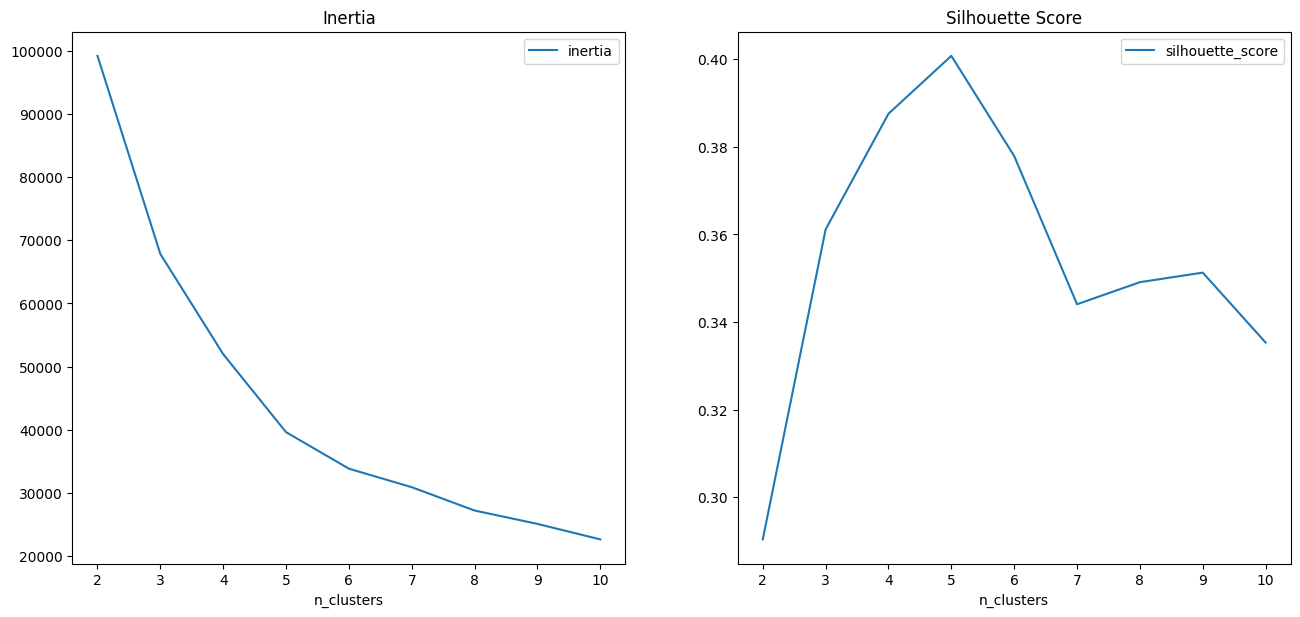

In [32]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(7)
plt.tight_layout(pad=5)

axs[0].set_title('Inertia')
results.plot(x='n_clusters', y='inertia', ax=axs[0])

axs[1].set_title('Silhouette Score')
results.plot(x='n_clusters', y='silhouette_score', ax=axs[1])

In [33]:
model = results.loc[results.n_clusters==5, 'model'].iloc[0]
Xy = X.copy()
Xy['segment'] = model.labels_
repeat_purchasers['segment'] = model.labels_

In [35]:
cluster_centers = pca.inverse_transform(model.cluster_centers_)
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(cluster_centers, columns=X.columns)
cluster_centers 

,n_orders,avg_days_to_order,avg_order_items,avg_item_value
0,4.408954,190.054872,1.452092,56.971889
1,2.282610,168.784291,1.444720,48.652218
2,2.143358,751.309628,1.482764,51.164215
3,2.382001,248.686065,1.442222,141.396183
4,10.014338,127.284016,1.465143,61.602238


In [36]:
Xy['segment'].value_counts()

segment
1    15855
0     6551
2     5046
3     2862
4      417
Name: count, dtype: int64

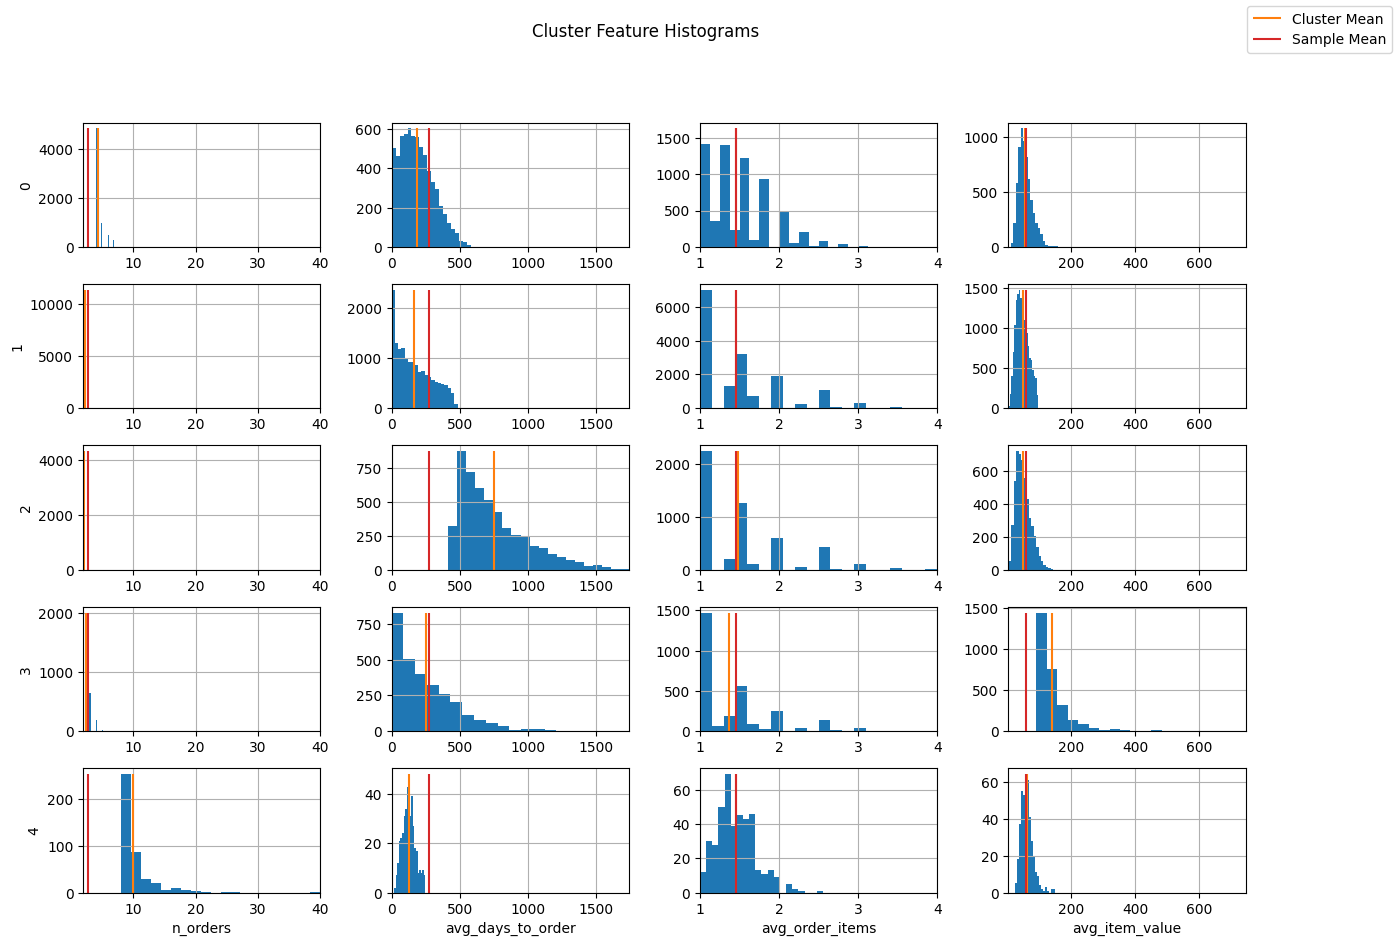

In [37]:
plot_clusters(X, model.labels_)

In [38]:
print('Cluster Mean / Sample Mean:', Xy.groupby('segment').mean() / Xy.drop(columns='segment').mean(), sep='\n')
print('\n'+80*'-'+'\n', 'Cluster Mean:', Xy.groupby('segment').mean(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Std:', Xy.groupby('segment').std(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Min:', Xy.groupby('segment').min(), sep='\n')
print('\n'+80*'-'+'\n', '\nCluster Max:', Xy.groupby('segment').max(), sep='\n')

Cluster Mean / Sample Mean:
         n_orders  avg_days_to_order  avg_order_items  avg_item_value
segment                                                              
0        1.559450           0.689001         1.000478        0.954561
1        0.807345           0.611069         1.003967        0.815703
2        0.758222           2.723389         1.020118        0.857409
3        0.842605           0.906378         0.940916        2.371707
4        3.542104           0.461819         1.003708        1.032107

--------------------------------------------------------------------------------

Cluster Mean:
          n_orders  avg_days_to_order  avg_order_items  avg_item_value
segment                                                               
0         4.408945         190.039350         1.453273       56.972177
1         2.282561         168.544245         1.458341       48.684597
2         2.143678         751.161217         1.481801       51.173758
3         2.382250         249

In [86]:
segment_map = {
    0: 'Loyal Customers',
    1: 'First Repeat Purchase',
    2: 'Long Time-To-Order',
    3: 'Purchasing High-Value Items',
    4: 'Loyal & Frequent Customers',
}

In [87]:
repeat_purchasers['segment'] = Xy['segment'].map(segment_map) 

In [88]:
repeat_purchasers.segment.value_counts()

segment
First Repeat Purchase          15855
Loyal Customers                 6551
Long Time-To-Order              5046
Purchasing High-Value Items     2862
Loyal & Frequent Customers       417
Name: count, dtype: int64

In [89]:
segment_cltv = repeat_purchasers.groupby('segment')[['active_days', 'avg_days_to_order', 'avg_order_value']].mean()
segment_cltv['cltv'] = (segment_cltv['active_days'] / segment_cltv['avg_days_to_order']) * segment_cltv['avg_order_value']
segment_cltv

,active_days,avg_days_to_order,avg_order_value,cltv
segment,,,,
First Repeat Purchase,223.616462,168.544245,72.321340,95.952504
Long Time-To-Order,836.996433,751.161217,76.943742,85.736105
Loyal & Frequent Customers,1084.803357,127.378365,89.810360,764.859711
Loyal Customers,641.697603,190.039350,83.057406,280.456329
Purchasing High-Value Items,335.374214,249.995813,190.770737,255.922630


In [90]:
customers_segmented = pd.concat([repeat_purchasers, one_off_customers, inactive_users])\
                        .sort_values('created_at')

In [91]:
customers_segmented.groupby(['segment'])['id'].count()

segment
First Repeat Purchase          15855
Long Time-To-Order              5046
Loyal & Frequent Customers       417
Loyal Customers                 6551
Never Ordered                  14938
One-Off Customers              38342
Purchasing High-Value Items     2862
Name: id, dtype: int64

In [92]:
customers_segmented.groupby(['segment', 'lifetime_status'])['id'].count()

segment                      lifetime_status  
First Repeat Purchase        Churn Likely         14299
                             Repeat Purchaser      1556
Long Time-To-Order           Churn Likely          1652
                             Repeat Purchaser      3394
Loyal & Frequent Customers   Churn Likely           251
                             Repeat Purchaser       166
Loyal Customers              Churn Likely          3803
                             Repeat Purchaser      2748
Never Ordered                Inactive             14938
One-Off Customers            One-Off Purchaser    38342
Purchasing High-Value Items  Churn Likely          2300
                             Repeat Purchaser       562
Name: id, dtype: int64

In [93]:
for country in customers_segmented.country.unique():
    customers_filtered = customers_segmented[customers_segmented.country==country]
    print('Country:', country)
    print(customers_filtered['segment'].value_counts() / customers_filtered.shape[0])
    print(50*'-')

Country: United States
segment
One-Off Customers              0.451937
First Repeat Purchase          0.191724
Never Ordered                  0.180098
Loyal Customers                0.079216
Long Time-To-Order             0.057602
Purchasing High-Value Items    0.034033
Loyal & Frequent Customers     0.005390
Name: count, dtype: float64
--------------------------------------------------
Country: South Korea
segment
One-Off Customers              0.464565
First Repeat Purchase          0.185781
Never Ordered                  0.177733
Loyal Customers                0.074223
Long Time-To-Order             0.058127
Purchasing High-Value Items    0.035323
Loyal & Frequent Customers     0.004248
Name: count, dtype: float64
--------------------------------------------------
Country: China
segment
One-Off Customers              0.457325
First Repeat Purchase          0.188725
Never Ordered                  0.176452
Loyal Customers                0.078167
Long Time-To-Order             0.060874

In [94]:
for gender in customers_segmented.gender.unique():
    customers_filtered = customers_segmented[customers_segmented.gender==gender]
    print('Gender:', gender)
    print(customers_filtered['segment'].value_counts() / customers_filtered.shape[0])
    print(50*'-')

Gender: F
segment
One-Off Customers              0.464300
First Repeat Purchase          0.191484
Never Ordered                  0.181090
Loyal Customers                0.072913
Long Time-To-Order             0.059170
Purchasing High-Value Items    0.027968
Loyal & Frequent Customers     0.003074
Name: count, dtype: float64
--------------------------------------------------
Gender: M
segment
One-Off Customers              0.447866
First Repeat Purchase          0.185751
Never Ordered                  0.174273
Loyal Customers                0.083438
Long Time-To-Order             0.061027
Purchasing High-Value Items    0.040643
Loyal & Frequent Customers     0.007001
Name: count, dtype: float64
--------------------------------------------------


In [95]:
for traffic_source in customers_segmented.traffic_source.unique():
    customers_filtered = customers_segmented[customers_segmented.traffic_source==traffic_source]
    print('Traffic Source:', traffic_source)
    print(customers_filtered['segment'].value_counts() / customers_filtered.shape[0])
    print(50*'-')

Traffic Source: Facebook
segment
One-Off Customers              0.459841
First Repeat Purchase          0.192316
Never Ordered                  0.171674
Loyal Customers                0.076027
Long Time-To-Order             0.060699
Purchasing High-Value Items    0.034335
Loyal & Frequent Customers     0.005109
Name: count, dtype: float64
--------------------------------------------------
Traffic Source: Organic
segment
One-Off Customers              0.456385
First Repeat Purchase          0.186664
Never Ordered                  0.177531
Loyal Customers                0.077232
Long Time-To-Order             0.061959
Purchasing High-Value Items    0.034640
Loyal & Frequent Customers     0.005590
Name: count, dtype: float64
--------------------------------------------------
Traffic Source: Email
segment
One-Off Customers              0.455240
First Repeat Purchase          0.190499
Never Ordered                  0.182382
Loyal Customers                0.077584
Long Time-To-Order         

# Save Pipeline 

In [96]:
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('kmeans', model)])

In [97]:
# with open('../models/cust_segment_pipe.pkl', 'wb') as f:
#     pkl.dump(pipe, f)

In [98]:
with open('../models/cust_segment_pipe.pkl', 'rb') as f:
    pipe_loaded = pkl.load(f)

In [99]:
y = pipe_loaded.predict(X)
(y == model.labels_).all()

np.True_

In [100]:
with open('../models/cust_segment_map.json', 'w') as f:
    json.dump(segment_map, f)

In [101]:
with open('../models/cust_segment_map.json', 'r') as f:
    segment_map_ = json.load(f)

In [102]:
segment_map_

{'0': 'Loyal Customers',
 '1': 'First Repeat Purchase',
 '2': 'Long Time-To-Order',
 '3': 'Purchasing High-Value Items',
 '4': 'Loyal & Frequent Customers'}